In [16]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

In [54]:
using Base.Threads
using BenchmarkTools
using Random, Distributions, Statistics

In [18]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

## Basic solving with CoSMO as the example

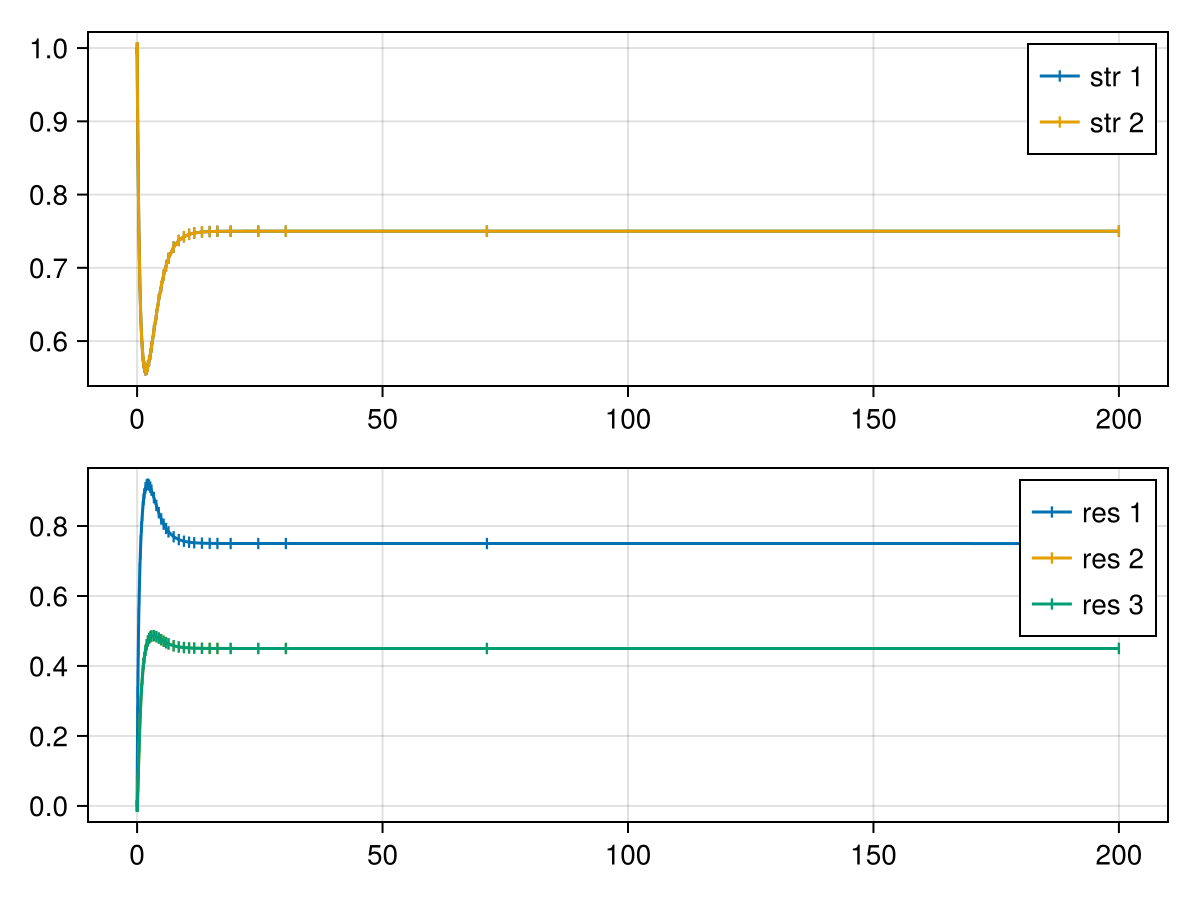

5-element Vector{Float64}:
 0.7500567884764349
 0.7500567884764349
 0.7499261224767086
 0.44998581480140554
 0.44998581480140554

In [4]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
params = make_sammicrmparams(2, 3;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
)

u0 = make_u0_smart(params;
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p, QNDF())

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

## Now lets do some random sampling

In [32]:
S = 20
M = 20

20

In [33]:
rsgj = RSGStevens1(S, M,1.,0.35,fill(0.,M),fill(0.,M)
)
ps = rsgj();

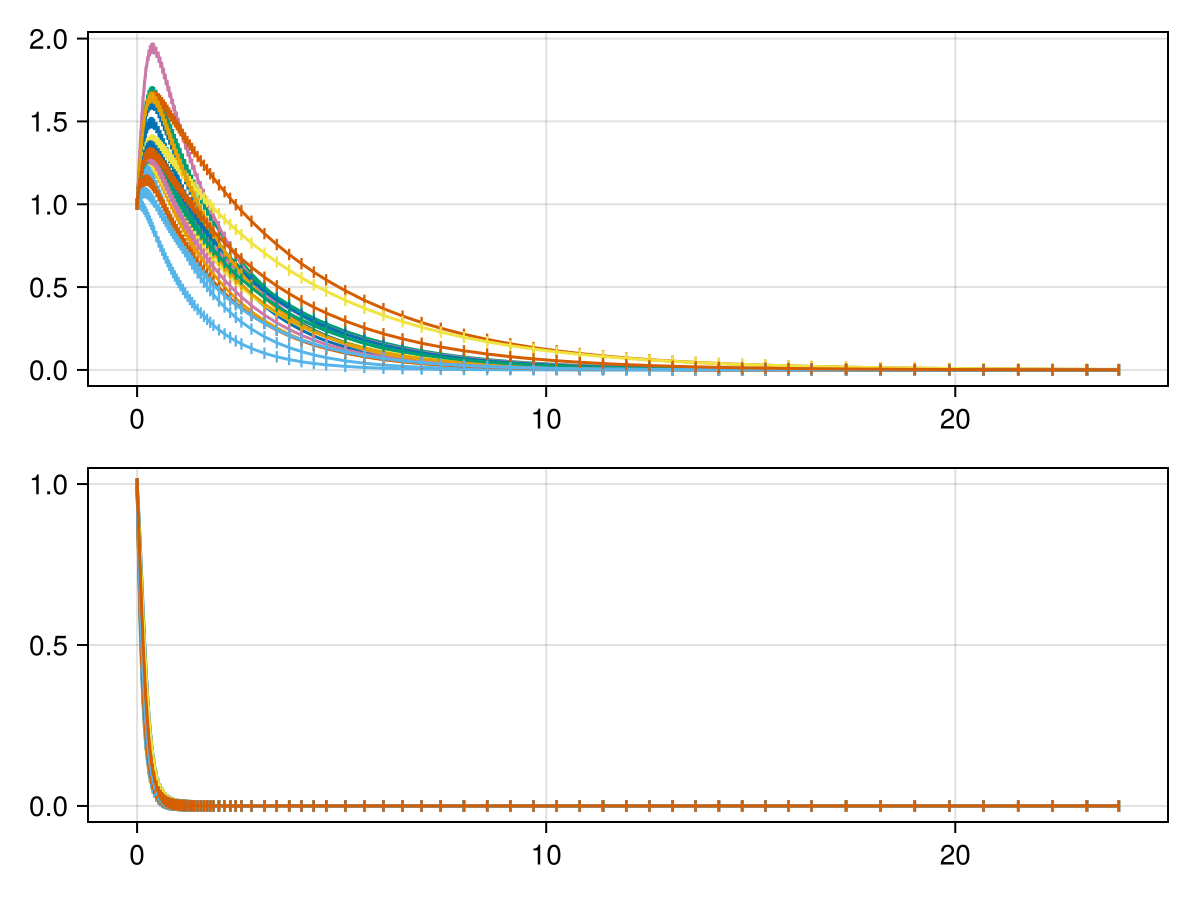

40-element Vector{Float64}:
  7.080450558678355e-6
  4.101383938253339e-6
  2.7859350094097272e-5
  4.281344681247457e-6
  6.685901380655427e-9
  0.002633925219737382
  4.692980070592264e-5
  1.2654041379813958e-5
  2.680863026442965e-5
  0.00017804901119582874
  ⋮
 -6.806702347817962e-6
  2.8603177470527054e-6
 -1.9890700800557533e-8
  5.732754908593384e-7
  2.971170632174903e-6
 -1.1343298564179317e-6
  5.052049292810849e-6
  1.9520539910234963e-6
  2.853121650609551e-6

In [34]:
u0 = make_u0_smart(ps; u0=fill(1.,S+M))
p = make_mmicrm_problem(ps, u0, 24)
s = solve(p, QNDF())

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]

## And finally a basic batch culture

In [150]:
#strain properties
S = 20
M = 20

rsgj = RSGStevens1(S, M,1.,0.35,fill(0.,M),fill(0.,M)
)
ps = rsgj();


In [151]:
# environmental properties
complexity = 0.5 # can only be between 0 and 1.
richness = 100 # total resource available

arr = fill(complexity,M)
media = rand(Dirichlet(arr)).*richness;

In [152]:
#make the initial condition
u = fill(0.,S+M)
u[1:S] .= 1.
u[S+1:S+M] .= media;

In [153]:
total_time = 100 # hrs
average_dilution_rate = 0.5 # per hour
n_dil = 10 # number of dilutions

epsilon = 1e-8 # extinction threshold

# calcualted parameters
t_dil = total_time/n_dil
dilution_factor = average_dilution_rate*t_dil

abundances = fill(0., (S, n_dil+1))
abundances[:,1] = u[1:S]

for i in 1:n_dil
    u0 = make_u0_smart(ps; u0=u)
    p = make_mmicrm_problem(ps, u0, t_dil)
    s = solve(p, QNDF())

    #display(plot_mmicrm_sol(s))
    # check for extinction
    s[end][1:S][s[end][1:S] .< epsilon] .= 0.
    abundances[:,i+1] = s[end][1:S]

    # update the state of the system
    # abundances
    u[1:S] = s[end][1:S]/dilution_factor
    # media
    new_composition = (1 - 1/dilution_factor).* media
    u[S+1:end] = s[end][S+1:end]/dilution_factor .+ new_composition
end

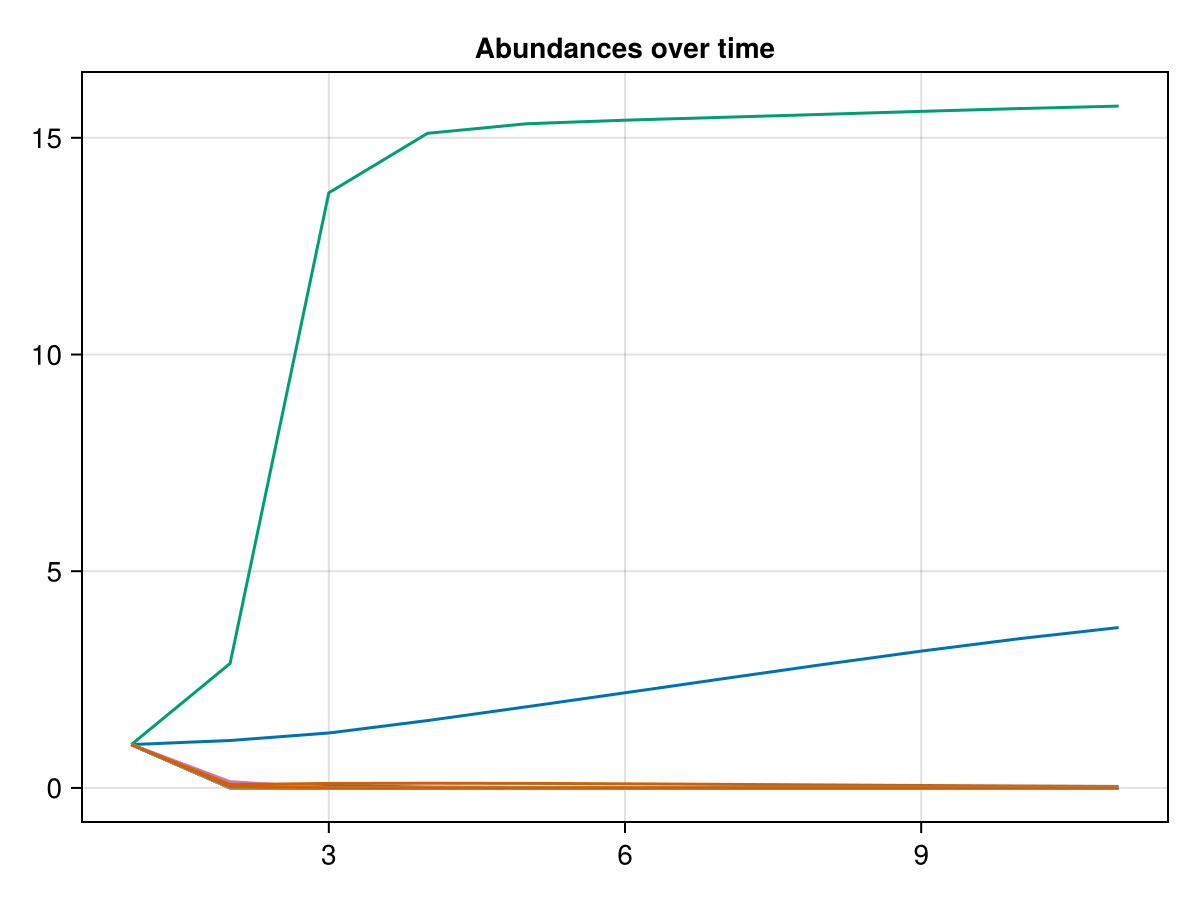

CairoMakie.Screen{IMAGE}


In [154]:
# visualizer for abundances over time
function plot_abundances(abundances)
    fig = Figure()
    ax = Axis(fig[1, 1], title="Abundances over time")
    for i in 1:size(abundances, 1)
        lines!(ax, 1:size(abundances, 2), abundances[i, :], label="Dilution $i")
    end
    return fig
end
fig = plot_abundances(abundances)
display(fig)

## Let's do it at varying dilution rates

In [183]:
# "experiment" properties
total_time = 100 # hrs
average_dilution_rate = 0.5 # per hour
dilutions = [5, 10, 15, 20, 25] # number of dilutions
n_replicates = 5 # number of replicates

epsilon = 1e-8 # extinction threshold

#strain properties
S = 100
M = 100

# environmental properties
complexity = 0.5 # can only be between 0 and 1.
richness = 100 # total resource available

# data storage
final_abundances = fill(0., (n_replicates, length(dilutions), S))

for j in 1:n_replicates

    # sample parameters
    rsgj = RSGStevens1(S, M,1.,0.35,fill(0.,M),fill(0.,M)
    )
    ps = rsgj();
    
    arr = fill(complexity,M)
    media = rand(Dirichlet(arr)).*richness;

    for i in 1:length(dilutions)
        n_dil = dilutions[i]
        t_dil = total_time/n_dil
        dilution_factor = average_dilution_rate*t_dil

        #make the initial condition
        u = fill(0.,S+M)
        u[1:S] .= 1.
        u[S+1:S+M] .= media;


        abundances = fill(0., (S, n_dil+1))
        abundances[:,1] = u[1:S]

        for i in 1:n_dil
            u0 = make_u0_smart(ps; u0=u)
            p = make_mmicrm_problem(ps, u0, t_dil)
            s = solve(p, QNDF())

            #display(plot_mmicrm_sol(s))
            # check for extinction
            state = s[end][1:S]
            state[abs.(state) .< epsilon] .= 0.
            
            abundances[:,i+1] = state

            # update the state of the system
            # abundances
            u[1:S] = state/dilution_factor
            # media
            new_composition = (1 - 1/dilution_factor).* media
            u[S+1:end] = state/dilution_factor .+ new_composition
        end

        final_abundances[j, i, :] = abundances[:, end]

    end
end


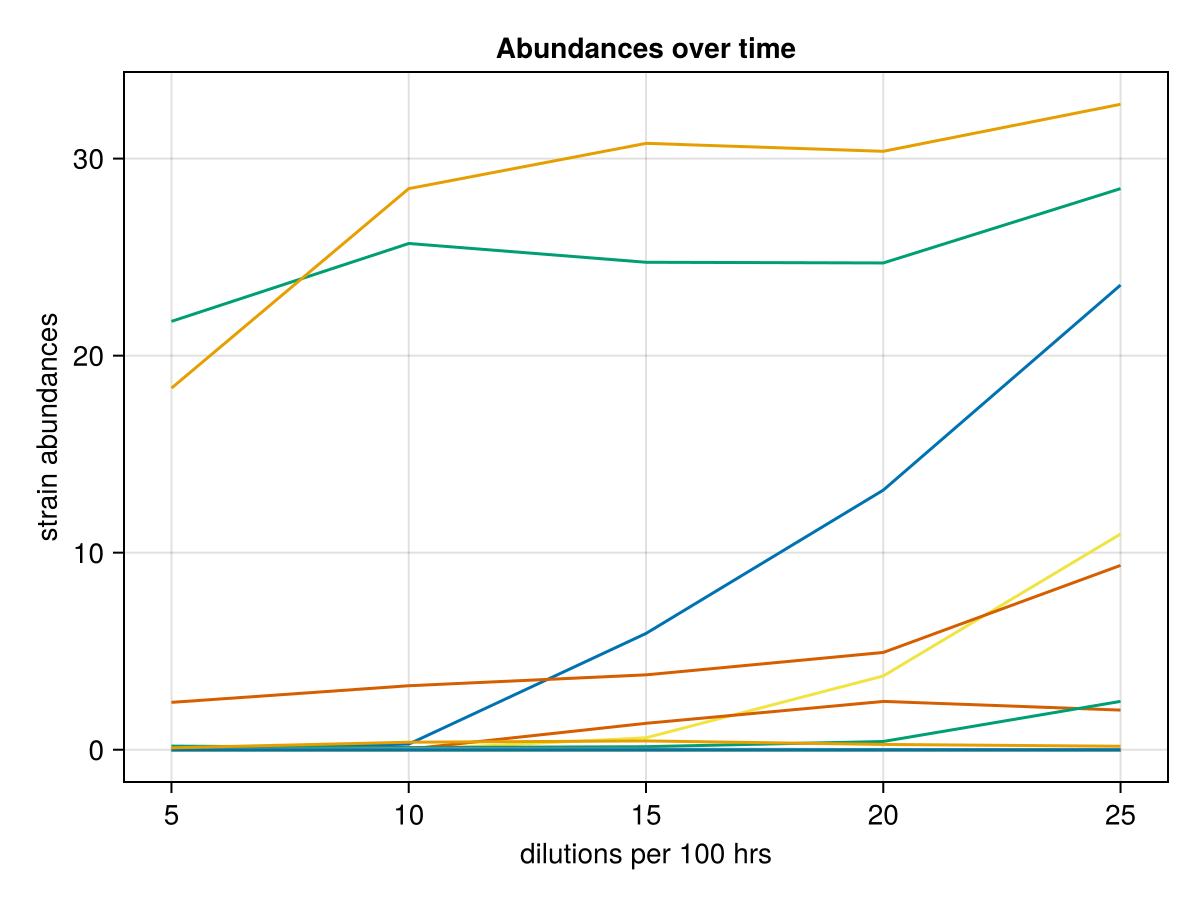

CairoMakie.Screen{IMAGE}


In [184]:
# time for some visualization

function plot_dil_abundances(abundances,dilutions)
    fig = Figure()
    ax = Axis(fig[1, 1],  xlabel="dilutions per 100 hrs", ylabel="strain abundances", title="Abundances over time")
    
    for j in 1:size(abundances, 2)
        lines!(ax, dilutions, abundances[:, j])
    end

    return fig
end

fig = plot_dil_abundances(final_abundances[1,:,:], dilutions)
display(fig)
